In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [2]:
datapath = Path.cwd() / "data"

In [3]:
figurepath = Path.cwd().parent / "figures"

In [4]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [5]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [6]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [7]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [9]:
jobids = []
params = []
data_xx = []
data_zz = []
folder_xx = datapath/"xx"
folder_zz = datapath/"zz"
files_xx = ["7621756_N19_RS.jld2","7621757_N19_RS.jld2"] #xx_pbc, xx_nn_pbc
files_zz = ["7510084_N19_RS.jld2","7501573_N19_RS.jld2","7443856_N19_RS.jld2","7443857_N19_RS.jld2",
"7621783_N19_RS.jld2","7621758_N19_RS.jld2","7501554_N19_RS.jld2","7466533_N19_RS.jld2","7466536_N19_RS.jld2"] #LOG: zz_pbc, zz_nn_pbc, sector zz_pbc, sector zz_nn_pbc, LIN:alpha = 0.75, 1.5, 3, 6, NN
for (i,file) in enumerate(files_xx):
    with h5py.File(folder_xx/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data_xx.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])

for (i,file) in enumerate(files_zz):
    with h5py.File(folder_zz/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data_zz.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
#for  i in range(1,len(files)):
 #       data[i] = np.concatenate(data[i],axis=2)
#T = np.arange(0,2.01,0.01)

In [10]:
N = 19
T = 10 ** np.linspace(-3,1,100)
Tlin = np.arange(0,2.51,0.01)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [11]:
def model(x,a,b):
    return a*x**b

In [12]:
data_zz[0].shape

(100, 19, 1)

In [17]:
len(data_zz)

9

# ZZ Commutator

In [18]:
res_zz = data_zz[0][:,:,0]
res_zz_nn = data_zz[1][:,:,0]
red_zz = np.zeros((res_zz.shape[0],N//2+1))
red_zz_nn = np.zeros((res_zz.shape[0],N//2+1))

res_zz_sector = data_zz[2][:,:,0]
res_zz_nn_sector = data_zz[3][:,:,0]
red_zz_sector = np.zeros((res_zz_sector.shape[0],N//2+1))
red_zz_nn_sector = np.zeros((res_zz_sector.shape[0],N//2+1))


res_zz_a075lin = data_zz[-5][:,:,0]
res_zz_a15lin = data_zz[-4][:,:,0]
res_zz_a3lin = data_zz[-3][:,:,0]
res_zz_a6lin = data_zz[-2][:,:,0]
res_zz_nnlin = data_zz[-1][:,:,0]
red_zz_a075lin = np.zeros((res_zz_a075lin.shape[0],N//2+1))
red_zz_a15lin = np.zeros((res_zz_a15lin.shape[0],N//2+1))
red_zz_a3lin = np.zeros((res_zz_a3lin.shape[0],N//2+1))
red_zz_a6lin = np.zeros((res_zz_a6lin.shape[0],N//2+1))
red_zz_nnlin = np.zeros((res_zz_nnlin.shape[0],N//2+1))

for j in range(0,N//2):
    red_zz[:,j] = 0.5*(res_zz[:,j]+res_zz[:,N-j-1])
    red_zz_nn[:,j] = 0.5*(res_zz_nn[:,j]+res_zz_nn[:,N-j-1])
    red_zz_sector[:,j] = 0.5*(res_zz_sector[:,j]+res_zz_sector[:,N-j-1])
    red_zz_nn_sector[:,j] = 0.5*(res_zz_nn_sector[:,j]+res_zz_nn_sector[:,N-j-1])
    red_zz_a075lin[:,j] = 0.5*(res_zz_a075lin[:,j]+res_zz_a075lin[:,N-j-1])
    red_zz_a15lin[:,j] = 0.5*(res_zz_a15lin[:,j]+res_zz_a15lin[:,N-j-1])
    red_zz_a3lin[:,j] = 0.5*(res_zz_a3lin[:,j]+res_zz_a3lin[:,N-j-1])
    red_zz_a6lin[:,j] = 0.5*(res_zz_a6lin[:,j]+res_zz_a6lin[:,N-j-1])
    red_zz_nnlin[:,j] = 0.5*(res_zz_nnlin[:,j]+res_zz_nnlin[:,N-j-1])
red_zz[:,N//2] = res_zz[:,N//2]
red_zz_nn[:,N//2] = res_zz_nn[:,N//2]
red_zz_sector[:,N//2] = res_zz_sector[:,N//2]
red_zz_nn_sector[:,N//2] = res_zz_nn_sector[:,N//2]
red_zz_a075lin[:,N//2] = res_zz_a075lin[:,N//2]
red_zz_a15lin[:,N//2] = res_zz_a15lin[:,N//2]
red_zz_a3lin[:,N//2] = res_zz_a3lin[:,N//2]
red_zz_a6lin[:,N//2] = res_zz_a6lin[:,N//2]
red_zz_nnlin[:,N//2] = res_zz_nnlin[:,N//2]

## Contour Plots

In [188]:
thresholds = [0.1,0.33,0.66]
fit_params075 = []
fit_errs075 = []
tvals075 = []
fit_params15 = []
fit_errs15 = []
tvals15 = []
fit_params3 = []
fit_errs3 = []
tvals3 = []
fit_params6 = []
fit_errs6 = []
tvals6 = []
fit_paramsnn = []
fit_errsnn = []
tvalsnn = []
for (i,th) in enumerate(thresholds):
    tvals075.append(T_transgression(Tlin,res_zz_a075lin,th))
    popt, pcov = curve_fit(model,rvals,tvals075[i])
    fit_params075.append(popt)
    fit_errs075.append(np.sqrt(np.diag(pcov)))

    tvals15.append(T_transgression(Tlin,res_zz_a15lin,th))
    popt, pcov = curve_fit(model,rvals,tvals15[i])
    fit_params15.append(popt)
    fit_errs15.append(np.sqrt(np.diag(pcov)))

    tvals3.append(T_transgression(Tlin,res_zz_a3lin,th))
    popt, pcov = curve_fit(model,rvals,tvals3[i])
    fit_params3.append(popt)
    fit_errs3.append(np.sqrt(np.diag(pcov)))

    tvals6.append(T_transgression(Tlin,res_zz_a6lin,th))
    popt, pcov = curve_fit(model,rvals,tvals6[i])
    fit_params6.append(popt)
    fit_errs6.append(np.sqrt(np.diag(pcov)))

    tvalsnn.append(T_transgression(Tlin,res_zz_nnlin,th))
    popt, pcov = curve_fit(model,rvals,tvalsnn[i])
    fit_paramsnn.append(popt)
    fit_errsnn.append(np.sqrt(np.diag(pcov)))

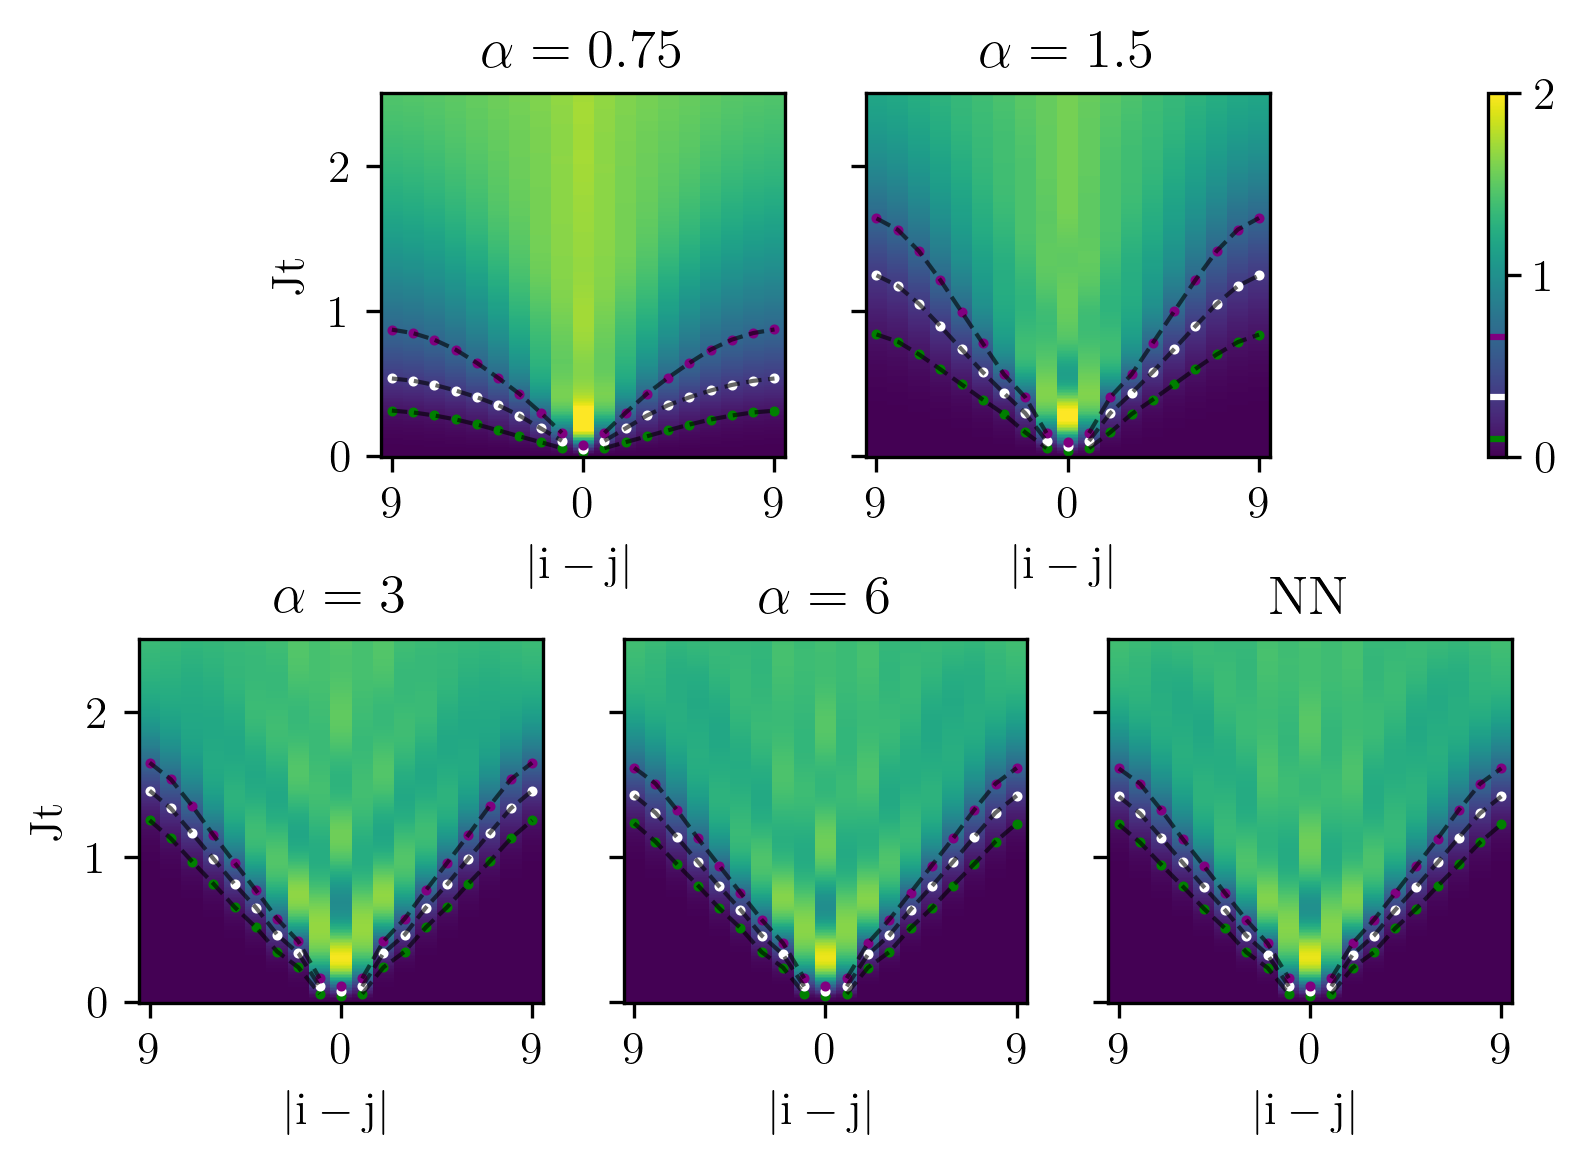

In [202]:
fig = plt.figure(figsize = set_size(subplots=(2,3)),dpi = 300)
gs = gridspec.GridSpec(2, 6,figure=fig)
gs.update(wspace=0.5, hspace=0.5)
ax1 = plt.subplot(gs[0, 1:3])
ax2 = plt.subplot(gs[0, 3:5])
ax3 = plt.subplot(gs[1, 0:2])
ax4 = plt.subplot(gs[1, 2:4])
ax5 = plt.subplot(gs[1, 4:6])
ax_cb = plt.subplot(gs[0, 5])
ax_cb.set_visible(False)

mcolors = ["green","white","purple"]

ax1.pcolormesh(range(0,N),Tlin,res_zz_a075lin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    ax1.plot(np.arange(0,N//2,1),tvals075[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax1.plot(np.arange(N//2+1,N,1),tvals075[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax1.scatter(np.arange(0,N,1),tvals075[i], marker= "o", c = mcolors[i], s = 2)
ax1.set_title(r"$\alpha = 0.75$")
ax1.set_ylabel("Jt")
ax1.set_xlabel(r"$\mathrm{|i-j|}$")
ax1.set_xticks([0,N//2,N-1])
ax1.set_xticklabels([9,0,9])


im = ax2.pcolormesh(range(0,N),Tlin,res_zz_a15lin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    ax2.plot(np.arange(0,N//2,1),tvals15[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax2.plot(np.arange(N//2+1,N,1),tvals15[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax2.scatter(np.arange(0,N,1),tvals15[i], marker= "o", c = mcolors[i], s = 2)
ax2.set_title(r"$\alpha = 1.5$")
ax2.set_yticklabels([])
ax2.set_xlabel(r"$\mathrm{|i-j|}$")
ax2.set_xticks([0,N//2,N-1])
ax2.set_xticklabels([9,0,9])


ax_cb2 = fig.colorbar(im, ax=ax_cb).ax
ax_cb2.plot([0,1],[thresholds[0]]*2,c=mcolors[0])
ax_cb2.plot([0,1],[thresholds[1]]*2,c=mcolors[1])
ax_cb2.plot([0,1],[thresholds[2]]*2,c=mcolors[2])



ax3.pcolormesh(range(0,N),Tlin,res_zz_a3lin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    ax3.plot(np.arange(0,N//2,1),tvals3[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax3.plot(np.arange(N//2+1,N,1),tvals3[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax3.scatter(np.arange(0,N,1),tvals3[i], marker= "o", c = mcolors[i], s = 2)
ax3.set_title(r"$\alpha = 3$")
ax3.set_ylabel("Jt")
ax3.set_xlabel(r"$\mathrm{|i-j|}$")
ax3.set_xticks([0,N//2,N-1])
ax3.set_xticklabels([9,0,9])

ax4.pcolormesh(range(0,N),Tlin,res_zz_a6lin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    #ax4.plot(np.arange(0,N,1),model(rvals,*fit_params6[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1)
    ax4.plot(np.arange(0,N//2,1),tvals6[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax4.plot(np.arange(N//2+1,N,1),tvals6[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax4.scatter(np.arange(0,N,1),tvals6[i], marker= "o", c = mcolors[i], s = 2)
ax4.set_title(r"$\alpha = 6$")
ax4.set_yticklabels([])
ax4.set_xlabel(r"$\mathrm{|i-j|}$")
ax4.set_xticks([0,N//2,N-1])
ax4.set_xticklabels([9,0,9])


ax5.pcolormesh(range(0,N),Tlin,res_zz_nnlin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    ax5.plot(np.arange(0,N//2,1),tvalsnn[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax5.plot(np.arange(N//2+1,N,1),tvalsnn[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax5.scatter(np.arange(0,N,1),tvalsnn[i], marker= "o", c = mcolors[i], s = 2)
ax5.set_title(r"NN")
ax5.set_yticklabels([])
ax5.set_xlabel(r"$\mathrm{|i-j|}$")
ax5.set_xticks([0,N//2,N-1])
ax5.set_xticklabels([9,0,9])


plt.savefig(figurepath/"contours_zz_all.pdf",format="pdf",bbox_inches='tight',dpi=600)

## Temporal

In [460]:
popt_zz = []
perr_zz = []
tfitmax = [35,35,25,25,25,25,25,15,15,15]
tfitmin = [0,0,0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,10):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_zz[tfitmin[j]:tfitmax[j],j])
    popt_zz.append(poptj)
    perr_zz.append(np.sqrt(np.diag(pcovj)))

In [461]:
popt_zz_nn = []
perr_zz_nn = []
tfitmax_nn = [65,65,60,60,55,55,50,50,50,50]
tfitmin_nn = [57,54,50,44,37,27,10,0,0,0]
for j in range(0,10):
    poptj_nn, pcovj_nn = curve_fit(model,T[tfitmin_nn[j]:tfitmax_nn[j]],red_zz_nn[tfitmin_nn[j]:tfitmax_nn[j],j])
    popt_zz_nn.append(poptj_nn)
    perr_zz_nn.append(np.sqrt(np.diag(pcovj_nn)))

In [462]:
popt_zz

[array([8.88590137e-11, 1.93812790e+00]),
 array([4.38482856e-10, 1.98523007e+00]),
 array([2.31483394e-09, 2.00008090e+00]),
 array([1.47456796e-08, 2.00033188e+00]),
 array([1.31429920e-07, 2.00047311e+00]),
 array([1.94951289e-06, 2.00361443e+00]),
 array([7.34764780e-05, 2.03633895e+00]),
 array([0.01105602, 2.05346895]),
 array([31.98789015,  1.99985337]),
 array([63.86990738,  1.99981888])]

In [463]:
popt_zz_nn

[array([ 0.05395365, 17.26544619]),
 array([ 0.26679122, 15.21029652]),
 array([ 2.36992581, 13.63965526]),
 array([ 7.06475914, 11.64991076]),
 array([32.71731754,  9.82302934]),
 array([43.11181294,  7.86423819]),
 array([97.41069287,  5.9090827 ]),
 array([33.64101937,  4.01586813]),
 array([23.7490864,  1.911186 ]),
 array([43.67480383,  1.88547002])]

In [464]:
for j in range(0,9):
    print(popt_zz[j][0]*(9-j)**12)

25.096410050634077
30.132312389692157
32.04028131987687
32.098134965732825
32.08738292986881
32.707398835696345
39.04841295623687
45.285448933396836
31.98789015012507


In [465]:
tcut_zz = np.zeros(9)
for j in range(0,9):
    tcut_zz[j] = (popt_zz[j][0]/popt_zz_nn[j][0])**(1/(popt_zz_nn[j][1]-popt_zz[j][1]))
    print(tcut_zz[j])

0.2672698839465042
0.21666571146268568
0.16822798679854936
0.1260184266639855
0.08446618695581246
0.05581831378872113
0.02624764000405423
0.016787806015695576
0.034777995644071226


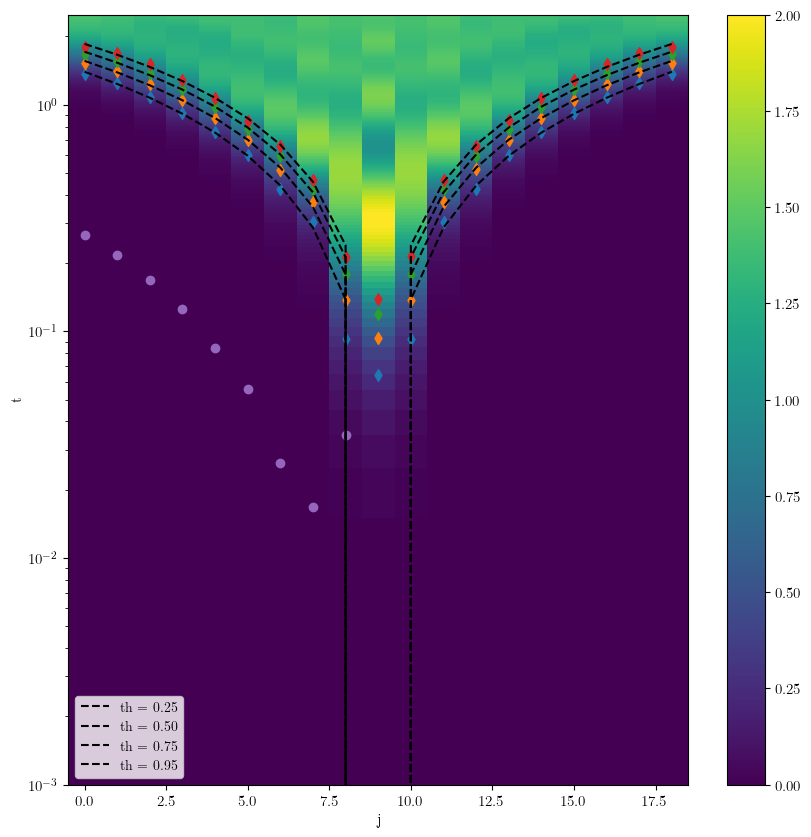

In [497]:
thresholds = [0.25,0.5,0.75,0.95]#,1.0]#,1.25]#,1.5,1.75,2]
fit_params = []
fit_errs = []
tvals = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(Tlin,res_zz_a6lin,th))
    popt, pcov = curve_fit(model,rvals,tvals[i])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))
plt.figure(figsize=(10,10))
linestyles = ["-","--","-."]
plt.pcolormesh(range(0,N),Tlin,res_zz_a6lin,cmap="viridis")#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    plt.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
    plt.scatter(np.arange(0,N,1),tvals[i], marker= "d")
plt.scatter(np.arange(0,9,1),tcut_zz)
plt.clim(0,2)
plt.colorbar()
plt.xlabel("j")
plt.yscale("log")
plt.ylabel("t")
#plt.colorbar()
plt.legend()
#plt.autoscale('tight')
plt.ylim(1e-3,2.5e0)
plt.show()

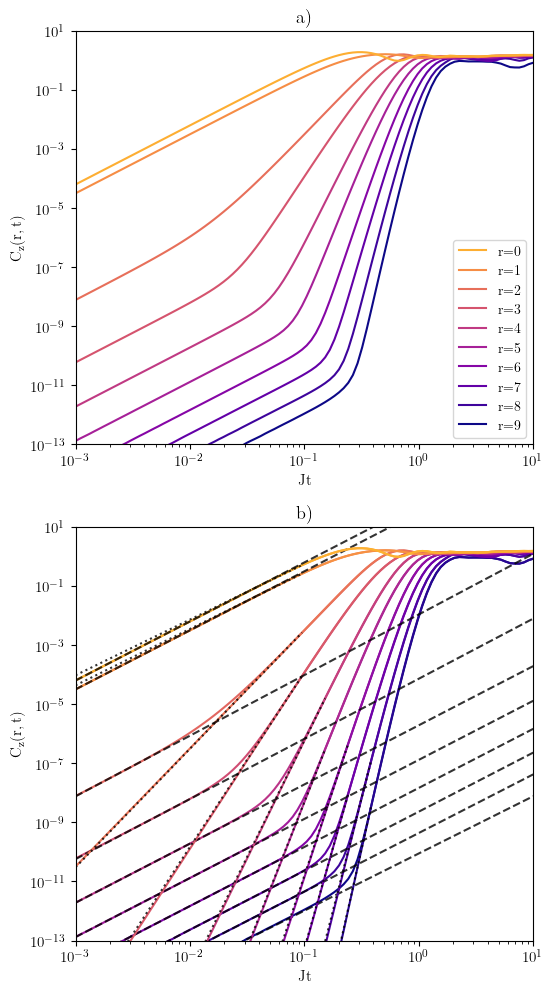

In [479]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=set_size(subplots=(2,1)))

NUM_COLORS = N//2+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax1.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax1.set_xscale("log")
ax1.set_yscale("log")
for j in range(0,N//2+1):
    ax1.plot(T,red_zz[:,j],label="r={}".format(rvals[j]))

handles, labels = ax1.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax1.set_xlabel(r"Jt")
ax1.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax1.set_xlim(1e-3,10)
ax1.set_ylim(1e-13,10)
ax1.set_title("a)")



NUM_COLORS = N+4
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax2.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax2.set_xscale("log")
ax2.set_yscale("log")
for j in range(0,N//2+1):
    ax2.plot(T,red_zz[:,j],label="r={}".format(rvals[j]))
    ax2.plot(T,red_zz_nn[:,j])
    if j <= 9:
        ax2.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt_zz[j][0],popt_zz[j][1]),color="black",alpha=0.8,ls="dashed")
    if j <= 9:
        ax2.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_zz_nn[j][0],popt_zz_nn[j][1]),color="black",alpha=0.8,ls="dotted")
        #ax2.scatter(tcut_zz[j],model(tcut_zz[j],popt_zz[j][0],popt_zz[j][1]),marker="x",c="black")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
#ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax2.set_xlabel(r"Jt")
ax2.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax2.set_xlim(1e-3,10)
ax2.set_ylim(1e-13,10)
ax2.set_title("b)")
plt.savefig(figurepath/"temp_zz.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()

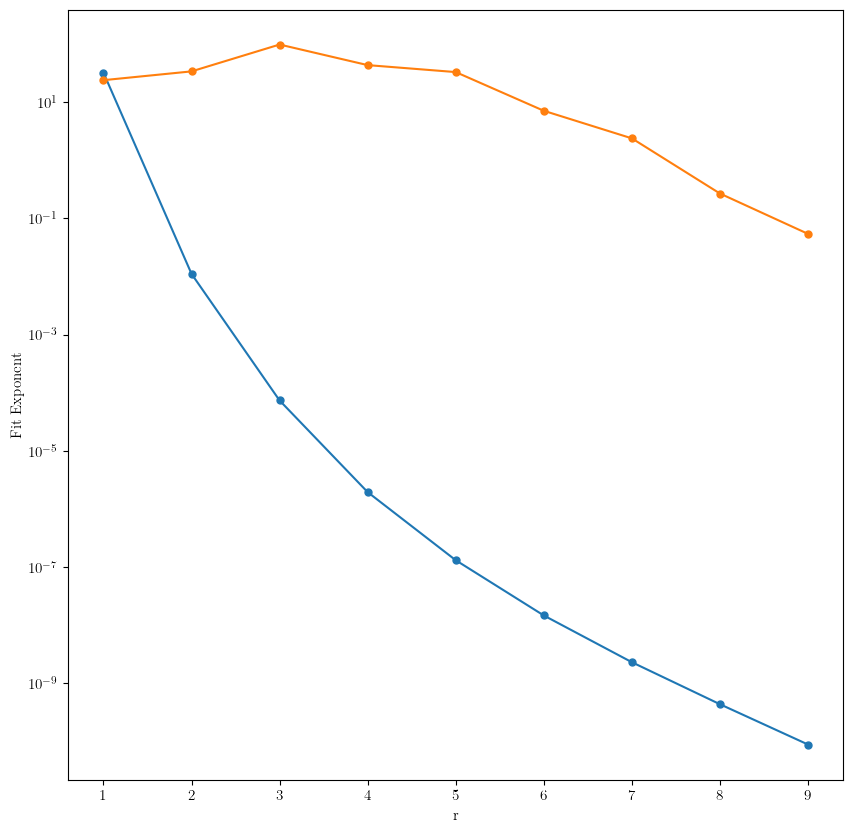

In [246]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rvals[0:9],[popt_zz[j][0] for j in range(0,9)],marker="o",ms=5)
ax.plot(rvals[0:9],[popt_zz_nn[j][0] for j in range(0,9)],marker="o",ms=5)
ax.set_ylabel("Fit Exponent")
ax.set_yscale("log")
ax.set_xlabel("r")
plt.show()

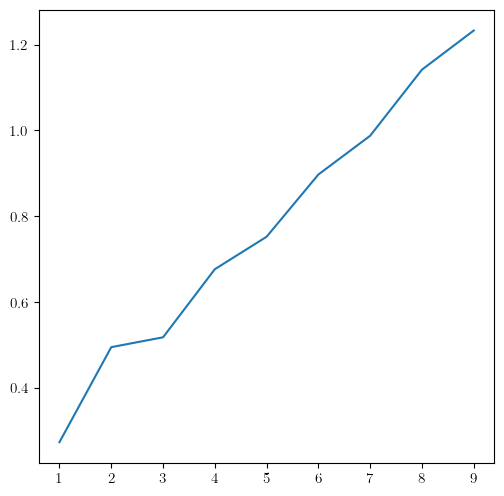

In [348]:
plt.plot(rvals[0:9],[(2/popt_zz_nn[j][0])**(1/popt_zz_nn[j][1]) for j in range(0,9)])

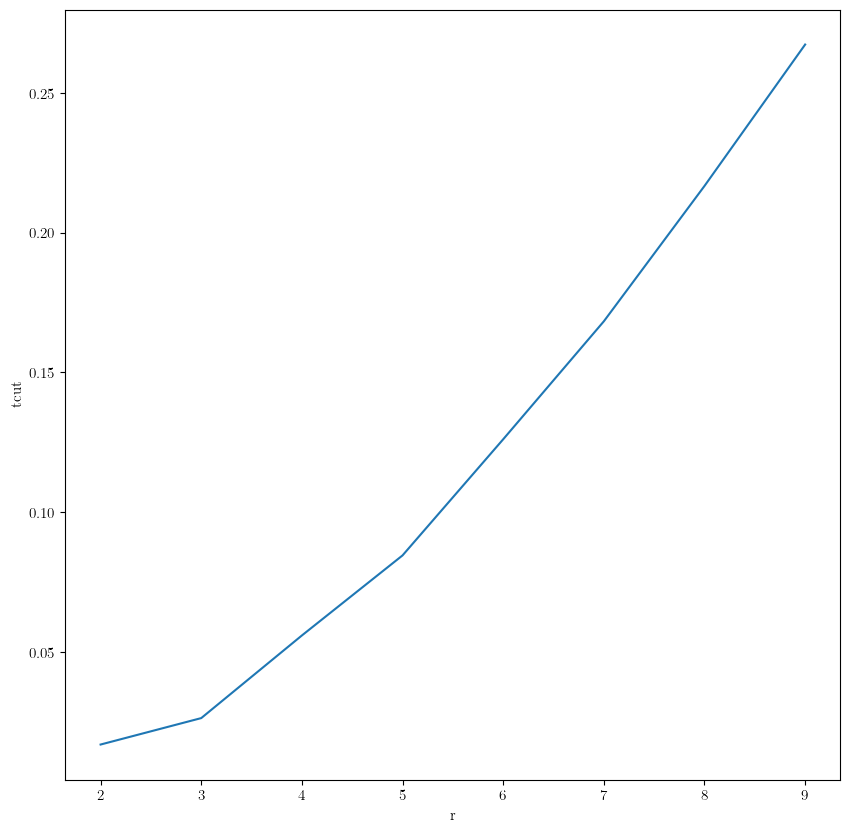

In [490]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rvals[0:8],tcut)
ax.set_ylabel("tcut")
ax.set_xlabel("r")
plt.show()

In [491]:
tcut

array([0.26726988, 0.21666571, 0.16822799, 0.12601843, 0.08446619,
       0.05581831, 0.02624764, 0.01678781])

## Spatial

/tmp/ipykernel_3987/1808668305.py:14: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(rvals[0:10],32/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
/tmp/ipykernel_3987/1808668305.py:31: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(rvals[0:10],32/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)


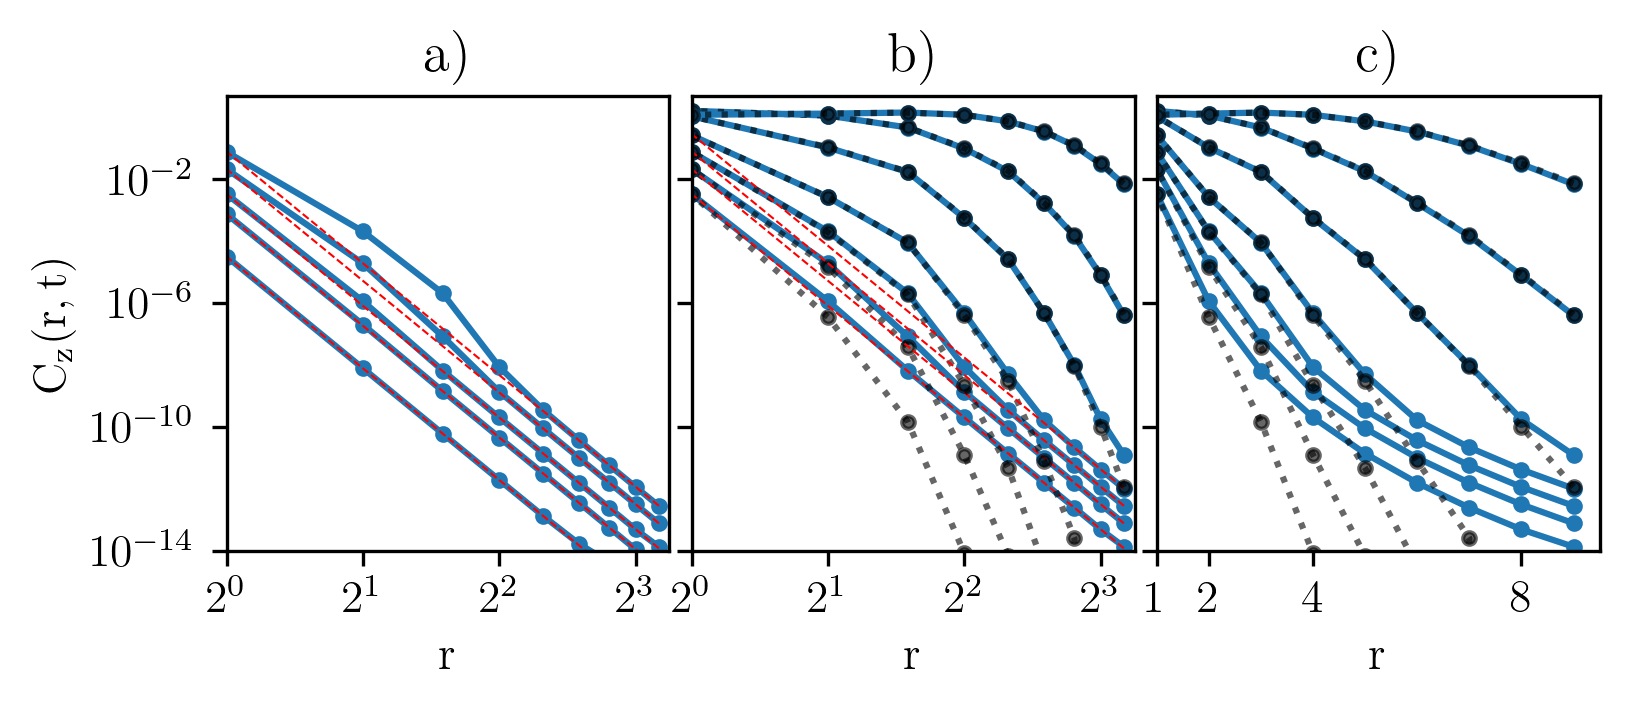

In [477]:
ts1 = [0.001,0.005,0.01,0.025,0.05]
Tis1 = []
for t in ts1:
    Tis1.append(np.argmin(np.abs(T-t)))

ts2 = [0.01,0.025,0.05,0.1,0.25,0.5,1]
Tis2 = []
for t in ts2:
    Tis2.append(np.argmin(np.abs(T-t)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=set_size(subplots=(1,3)),dpi=300,sharey=True)
for ti in Tis1:
    ax1.plot(rvals[0:10],red_zz[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax1.plot(rvals[0:10],32/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)

ax1.set_xlabel("r")
ax1.set_xscale("log",base=2)
ax1.set_yscale("log")
ax1.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax1.set_ylim(1e-14,5)
ax1.set_xlim(1,N//2+0.5)
ax1.set_xticks([1,2,4,8])
ax1.set_title("a)")
#ax1.legend(loc="lower left")

ind = 0
for ti in Tis2:
    ax2.plot(rvals[0:10],red_zz[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax2.plot(rvals[0:10],red_zz_nn[ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    if ind <= 3:
        ax2.plot(rvals[0:10],32/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
        ind += 1

ax2.set_xlabel("r")
ax2.set_xscale("log",base=2)
ax2.set_yscale("log")
ax2.set_xlim(1,N//2+0.5)
ax2.set_xticks([1,2,4,8])
ax2.set_title("b)")



for ti in Tis2:
    ax3.plot(rvals[0:10],red_zz[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax3.plot(rvals[0:10],red_zz_nn[ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    
ax3.set_xlabel("r")
ax3.set_yscale("log")
ax3.set_xlim(1,N//2+0.5)
ax3.set_xticks([1,2,4,8])
ax3.set_title("c)")


plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig(figurepath/"spat_zz.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()

# ZZ Sector

In [525]:
popt_zz_sector = []
perr_zz_sector = []
tfitmax = [35,35,25,25,25,25,25,15,15,15]
tfitmin = [0,0,0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,10):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_zz_sector[tfitmin[j]:tfitmax[j],j])
    popt_zz_sector.append(poptj)
    perr_zz_sector.append(np.sqrt(np.diag(pcovj)))

In [526]:
for j in range(0,9):
    print(popt_zz_sector[j][0]*(9-j)**12/(popt_zz[j][0]*(9-j)**12))

1.4191878727364193
1.0880677561114558
1.1020610389352112
1.0522875791311348
1.0523693060153132
1.0524850223514535
1.0807680502214183
1.0572047185493185
1.0532410626258089


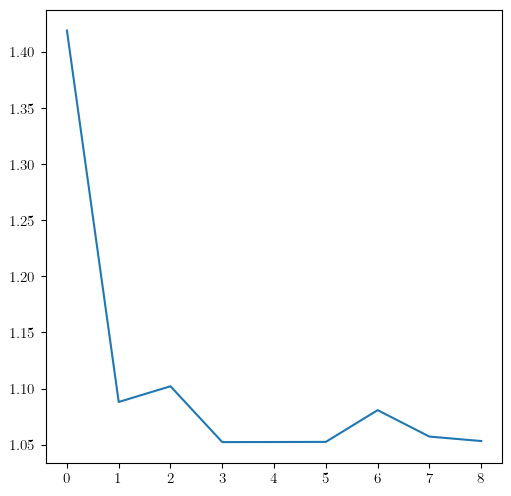

In [520]:
plt.plot([popt_zz_sector[j][0]*(9-j)**12/(popt_zz[j][0]*(9-j)**12) for j in range(9)])

In [511]:
for j in range(0,9):
    print(popt_zz[j][0]*(9-j)**12)

25.096410050634077
30.132312389692157
32.04028131987687
32.098134965732825
32.08738292986881
32.707398835696345
39.04841295623687
45.285448933396836
31.98789015012507


In [513]:
for j in range(0,9):
    print(perr_zz[j][0]*(9-j)**12)

3.7221821025367565
0.7863027342194208
2.0614231087861707
0.2865520772145364
0.029829301613969676
0.04481965429055454
0.638768081711669
1.1045527222233695
0.002203704512330084


In [458]:
popt_zz_nn_sector = []
perr_zz_nn_sector = []
tfitmax_nn = [65,65,60,60,55,55,50,50,50,50]
tfitmin_nn = [57,54,50,44,37,27,10,0,0,0]
for j in range(0,10):
    poptj_nn, pcovj_nn = curve_fit(model,T[tfitmin_nn[j]:tfitmax_nn[j]],red_zz_nn_sector[tfitmin_nn[j]:tfitmax_nn[j],j])
    popt_zz_nn_sector.append(poptj_nn)
    perr_zz_nn_sector.append(np.sqrt(np.diag(pcovj_nn)))

In [519]:
tcut_zz_sector = np.zeros(9)
for j in range(0,9):
    tcut_zz_sector[j] = (popt_zz_sector[j][0]/popt_zz_nn_sector[j][0])**(1/(popt_zz_nn_sector[j][1]-popt_zz_sector[j][1]))
    print(tcut_zz_sector[j])

0.26680814391525653
0.2141536480359549
0.16641137861670305
0.12447032801975096
0.0833574026215424
0.0552827304489809
0.025960330613496452
0.01687966314079242
0.03576105813288612


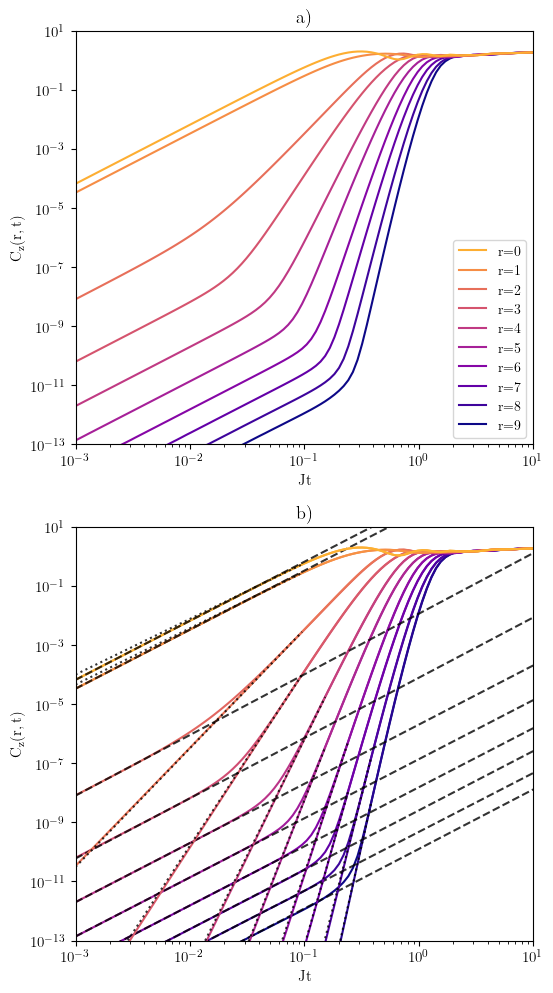

In [468]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=set_size(subplots=(2,1)))

NUM_COLORS = N//2+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax1.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax1.set_xscale("log")
ax1.set_yscale("log")
for j in range(0,N//2+1):
    ax1.plot(T,red_zz_sector[:,j],label="r={}".format(rvals[j]))

handles, labels = ax1.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax1.set_xlabel(r"Jt")
ax1.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax1.set_xlim(1e-3,10)
ax1.set_ylim(1e-13,10)
ax1.set_title("a)")



NUM_COLORS = N+4
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax2.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax2.set_xscale("log")
ax2.set_yscale("log")
for j in range(0,N//2+1):
    ax2.plot(T,red_zz_sector[:,j],label="r={}".format(rvals[j]))
    ax2.plot(T,red_zz_nn_sector[:,j])
    if j <= 9:
        ax2.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt_zz_sector[j][0],popt_zz_sector[j][1]),color="black",alpha=0.8,ls="dashed")
    if j <= 9:
        ax2.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_zz_nn_sector[j][0],popt_zz_nn_sector[j][1]),color="black",alpha=0.8,ls="dotted")
        #ax2.scatter(tcut_zz[j],model(tcut_zz[j],popt_zz[j][0],popt_zz[j][1]),marker="x",c="black")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
#ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax2.set_xlabel(r"Jt")
ax2.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax2.set_xlim(1e-3,10)
ax2.set_ylim(1e-13,10)
ax2.set_title("b)")
#plt.savefig(figurepath/"temp_xx.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()

# XX Commutator

In [78]:
res_xx = data_xx[0][:,:,0,0]
res_xx_nn = data_xx[1][:,:,0,0]
red_xx = np.zeros((res_xx.shape[0],N//2+1))
red_xx_nn = np.zeros((res_xx.shape[0],N//2+1))

for j in range(0,N//2):
    red_xx[:,j] = 0.5*(res_xx[:,j]+res_xx[:,N-j-1])
    red_xx_nn[:,j] = 0.5*(res_xx_nn[:,j]+res_xx_nn[:,N-j-1])
red_xx[:,N//2] = res_xx[:,N//2]
red_xx_nn[:,N//2] = res_xx_nn[:,N//2]

## Contour Plots

In [79]:
Tlin = np.arange(0,2.5+0.01,0.01)

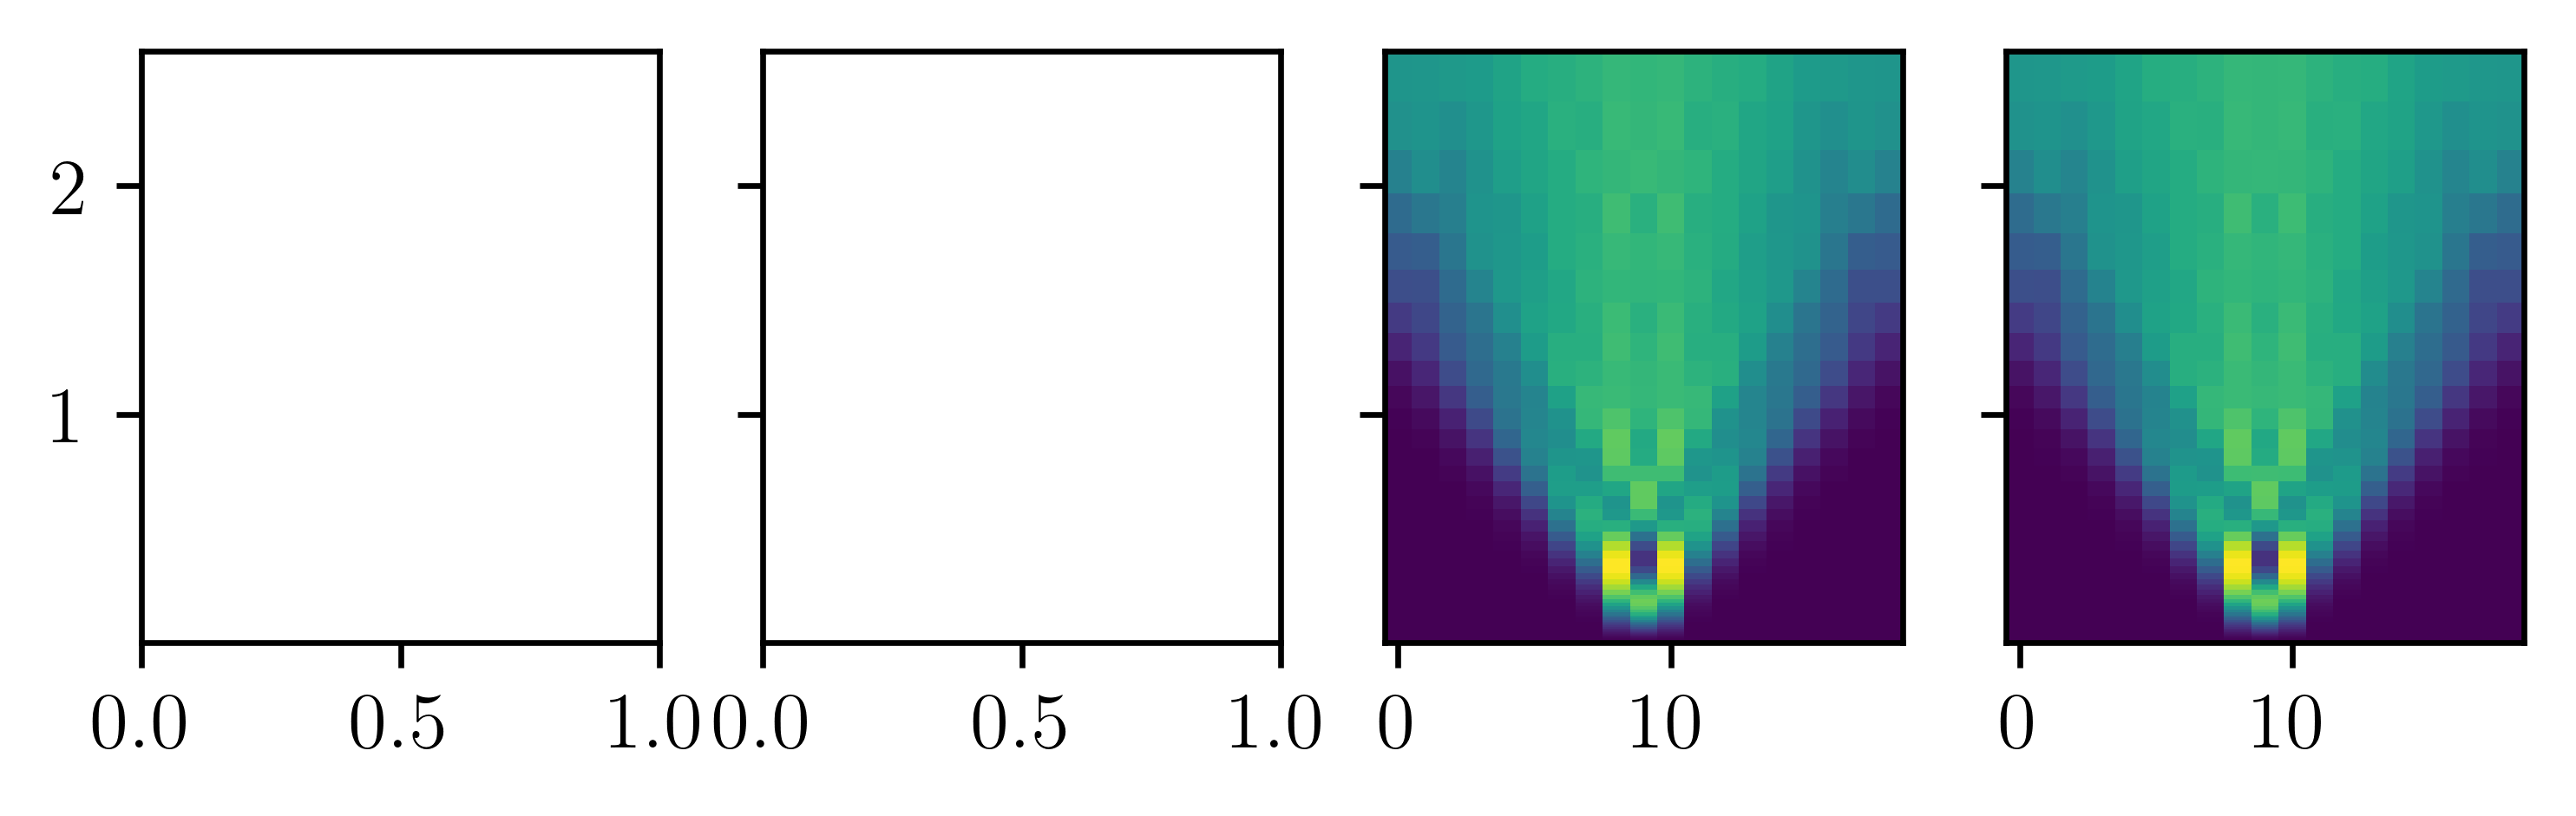

In [82]:
fig, axs = plt.subplots(1, 4,figsize=set_size(subplots=(1,4)),sharey=True,dpi=600)

axs[2].pcolormesh(range(0,N),T[0:85],res_xx[0:85,:],cmap="viridis")
axs[3].pcolormesh(range(0,N),T[0:85],res_xx_nn[0:85,:],cmap="viridis")
#plt.subplots_adjust(wspace=0.05, hspace=0.05)

## Temporal

In [233]:
popt_xx = []
perr_xx = []
tfitmax = [35,35,25,25,25,25,25,15,15]
tfitmin = [0,0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,9):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_xx[tfitmin[j]:tfitmax[j],j])
    popt_xx.append(poptj)
    perr_xx.append(np.sqrt(np.diag(pcovj)))

In [234]:
for j in range(0,9):
    print(popt_xx[j][0]*(9-j)**12)

84.45991172748792
80.81778636177727
83.12270052088189
80.56392348024458
81.47445321414985
84.00041106917259
107.26875452065548
142.26806564358196
79.89100757349605


In [236]:
popt_xx_nn = []
perr_xx_nn = []
tfitmax_nn = [65,65,60,60,55,55,50,50,50]
tfitmin_nn = [57,54,50,44,37,27,10,0,0]
for j in range(0,9):
    poptj_nn, pcovj_nn = curve_fit(model,T[tfitmin_nn[j]:tfitmax_nn[j]],red_xx_nn[tfitmin_nn[j]:tfitmax_nn[j],j])
    popt_xx_nn.append(poptj_nn)
    perr_xx_nn.append(np.sqrt(np.diag(pcovj_nn)))

In [238]:
for j in range(0,9):
    print(popt_xx_nn[j][0])

0.1413073561157257
0.7037356835904871
6.218298612477575
19.323677380072308
83.90046688892014
123.89178302075211
237.99393116951376
106.46503358796049
51.934375555691645


In [239]:
tcut_xx = np.zeros(8)
Tindx = []
for j in range(0,8):
    tcut_xx[j] = (popt_xx[j][0]/popt_xx_nn[j][0])**(1/(popt_xx_nn[j][1]-popt_xx[j][1]))
    print(tcut_xx[j])
    Tindx.append(np.argmin(np.abs(tcut_xx[j]-T)))

0.26906346824121363
0.21461092012297642
0.16734827553280093
0.12337780043732105
0.08398187213591235
0.05313875335029451
0.026433664237588132
0.01309425093054745


In [240]:
np.arange(0,N//2+1,1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

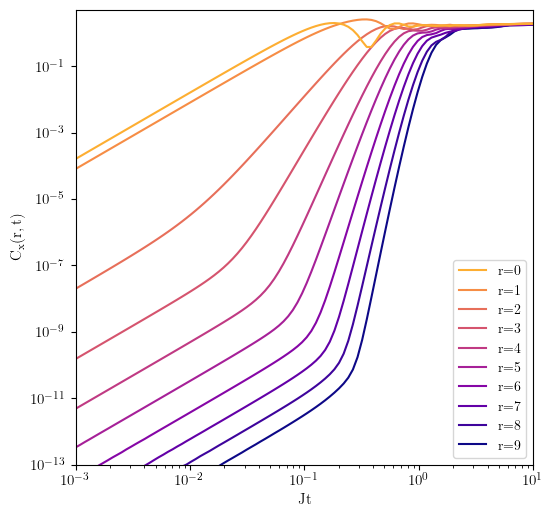

In [293]:
NUM_COLORS = N//2+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax.set_xscale("log")
ax.set_yscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red_xx[:,j],label="r={}".format(rvals[j]))
    #ax.plot(T,red_xx_nn[:,j])
    #if j <= 7:
    #    ax.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt[j][0],popt[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_nn[j][0],popt_nn[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.scatter(tcut[j],model(tcut[j],popt[j][0],popt[j][1]),marker="x",c="black")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_xlim(1e-3,10)
ax.set_ylim(1e-13,5)
plt.show()

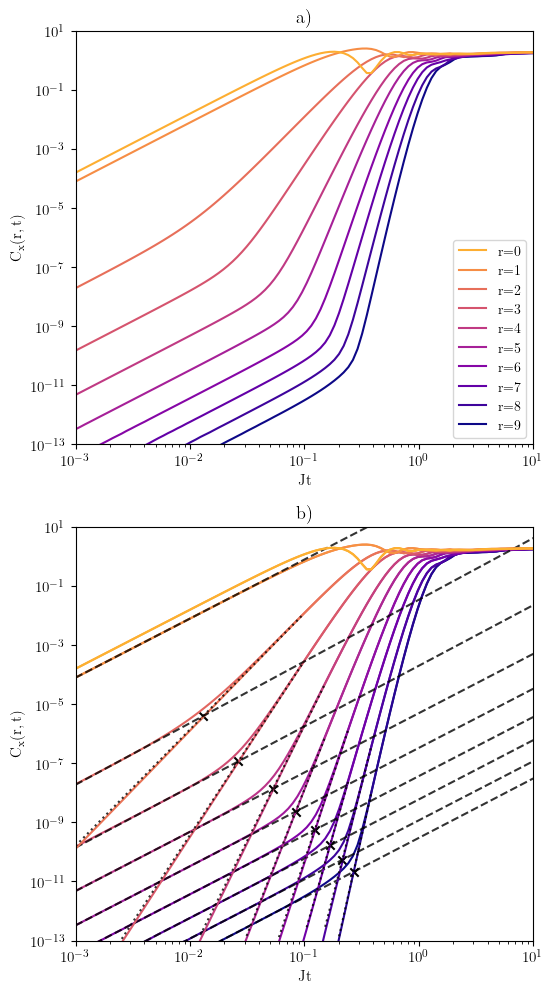

In [289]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=set_size(subplots=(2,1)))

NUM_COLORS = N//2+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax1.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax1.set_xscale("log")
ax1.set_yscale("log")
for j in range(0,N//2+1):
    ax1.plot(T,red_xx[:,j],label="r={}".format(rvals[j]))
    #ax.plot(T,red_xx_nn[:,j])
    #if j <= 7:
    #    ax.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt[j][0],popt[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_nn[j][0],popt_nn[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.scatter(tcut[j],model(tcut[j],popt[j][0],popt[j][1]),marker="x",c="black")

handles, labels = ax1.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax1.set_xlabel(r"Jt")
ax1.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax1.set_xlim(1e-3,10)
ax1.set_ylim(1e-13,10)
ax1.set_title("a)")



NUM_COLORS = N+4
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax2.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax2.set_xscale("log")
ax2.set_yscale("log")
for j in range(0,N//2+1):
    ax2.plot(T,red_xx[:,j],label="r={}".format(rvals[j]))
    ax2.plot(T,red_xx_nn[:,j])
    if j <= 8:
        ax2.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt_xx[j][0],popt_xx[j][1]),color="black",alpha=0.8,ls="dashed")
    if j <= 7:
        ax2.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_xx_nn[j][0],popt_xx_nn[j][1]),color="black",alpha=0.8,ls="dotted")
        ax2.scatter(tcut_xx[j],model(tcut_xx[j],popt_xx[j][0],popt_xx[j][1]),marker="x",c="black")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
#ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax2.set_xlabel(r"Jt")
ax2.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax2.set_xlim(1e-3,10)
ax2.set_ylim(1e-13,10)
ax2.set_title("b)")
plt.savefig(figurepath/"temp_xx.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()

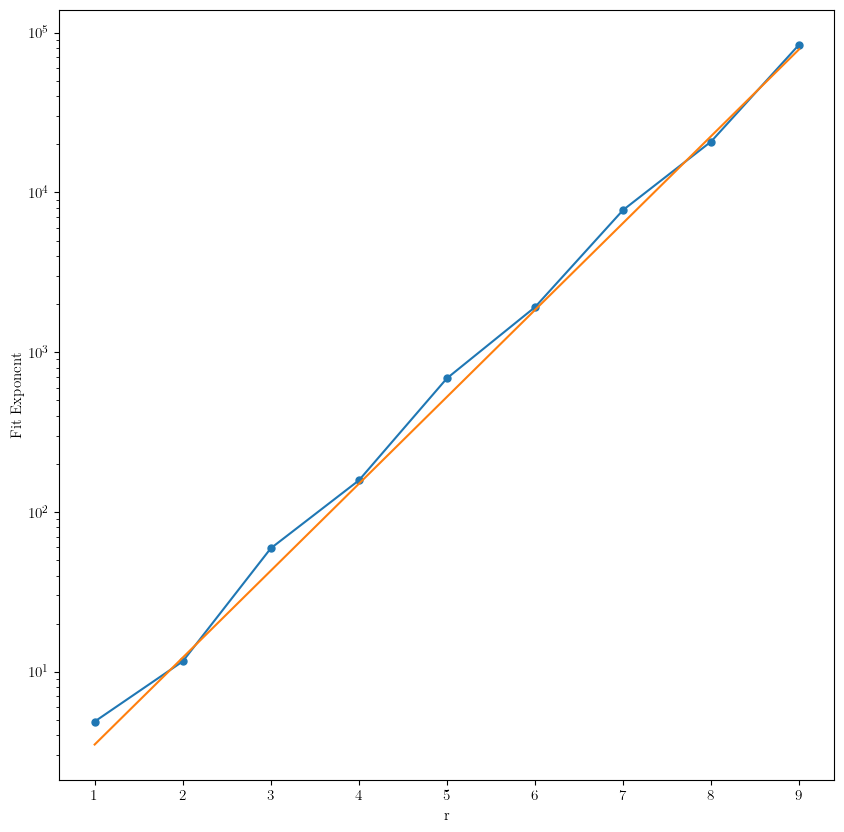

In [337]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#ax.plot(rvals[0:9],[popt_xx[j][0] for j in range(0,9)],marker="o",ms=5)
ax.plot(rvals[0:9],[(popt_zz_nn[j][0]*np.math.factorial(rvals[j])**2)**0.5 for j in range(0,9)],marker="o",ms=5)
ax.plot(rvals[0:9],3.5**rvals[0:9])
ax.set_ylabel("Fit Exponent")
ax.set_yscale("log")
ax.set_xlabel("r")
plt.show()

In [333]:
popt_zz_nn

[array([ 0.05395365, 17.26544619]),
 array([ 0.26679122, 15.21029652]),
 array([ 2.36992581, 13.63965526]),
 array([ 7.06475914, 11.64991076]),
 array([32.71731754,  9.82302934]),
 array([43.11181294,  7.86423819]),
 array([97.41069287,  5.9090827 ]),
 array([33.64101937,  4.01586813]),
 array([23.7490864,  1.911186 ])]

In [342]:
(4/3*2*2)**2

28.444444444444443

## Spatial

In [295]:
ts1 = [0.001,0.005,0.01,0.025,0.05]
Tis1 = []
for t in ts1:
    Tis1.append(np.argmin(np.abs(T-t)))

ts2 = [0.01,0.025,0.05,0.1,0.25,0.5,1]
Tis2 = []
for t in ts2:
    Tis2.append(np.argmin(np.abs(T-t)))


/tmp/ipykernel_3987/1369915708.py:4: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(rvals[0:10],5*16/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
/tmp/ipykernel_3987/1369915708.py:21: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(rvals[0:10],5*16/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)


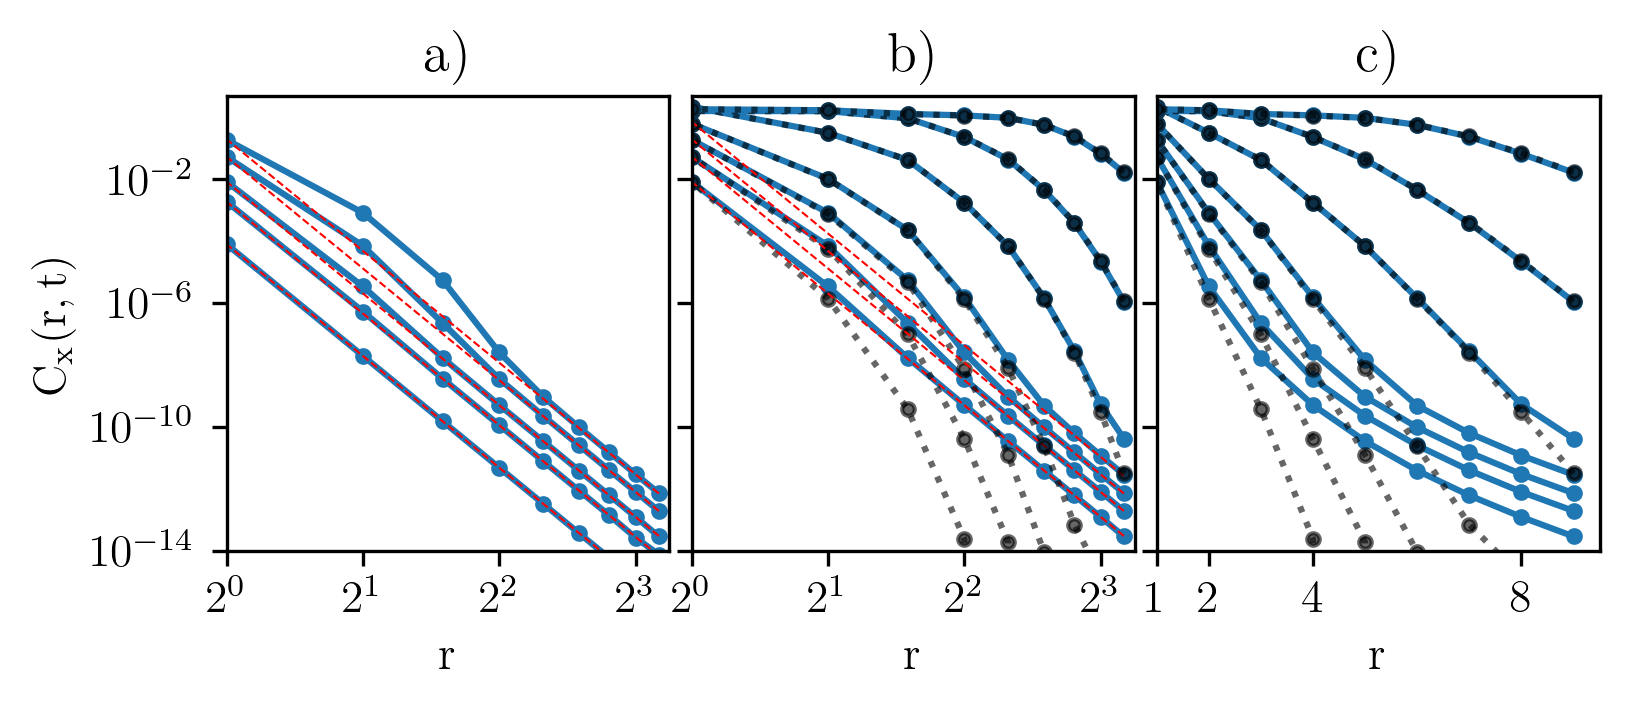

In [315]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=set_size(subplots=(1,3)),dpi=300,sharey=True)
for ti in Tis1:
    ax1.plot(rvals[0:10],red_xx[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax1.plot(rvals[0:10],5*16/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)

ax1.set_xlabel("r")
ax1.set_xscale("log",base=2)
ax1.set_yscale("log")
ax1.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax1.set_ylim(1e-14,5)
ax1.set_xlim(1,N//2+0.5)
ax1.set_xticks([1,2,4,8])
ax1.set_title("a)")
#ax1.legend(loc="lower left")

ind = 0
for ti in Tis2:
    ax2.plot(rvals[0:10],red_xx[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax2.plot(rvals[0:10],red_xx_nn[ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    if ind <= 3:
        ax2.plot(rvals[0:10],5*16/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
        ind += 1

ax2.set_xlabel("r")
ax2.set_xscale("log",base=2)
ax2.set_yscale("log")
ax2.set_xlim(1,N//2+0.5)
ax2.set_xticks([1,2,4,8])
ax2.set_title("b)")



for ti in Tis2:
    ax3.plot(rvals[0:10],red_xx[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax3.plot(rvals[0:10],red_xx_nn[ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    
ax3.set_xlabel("r")
ax3.set_yscale("log")
ax3.set_xlim(1,N//2+0.5)
ax3.set_xticks([1,2,4,8])
ax3.set_title("c)")


plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.show()

# Combined figures

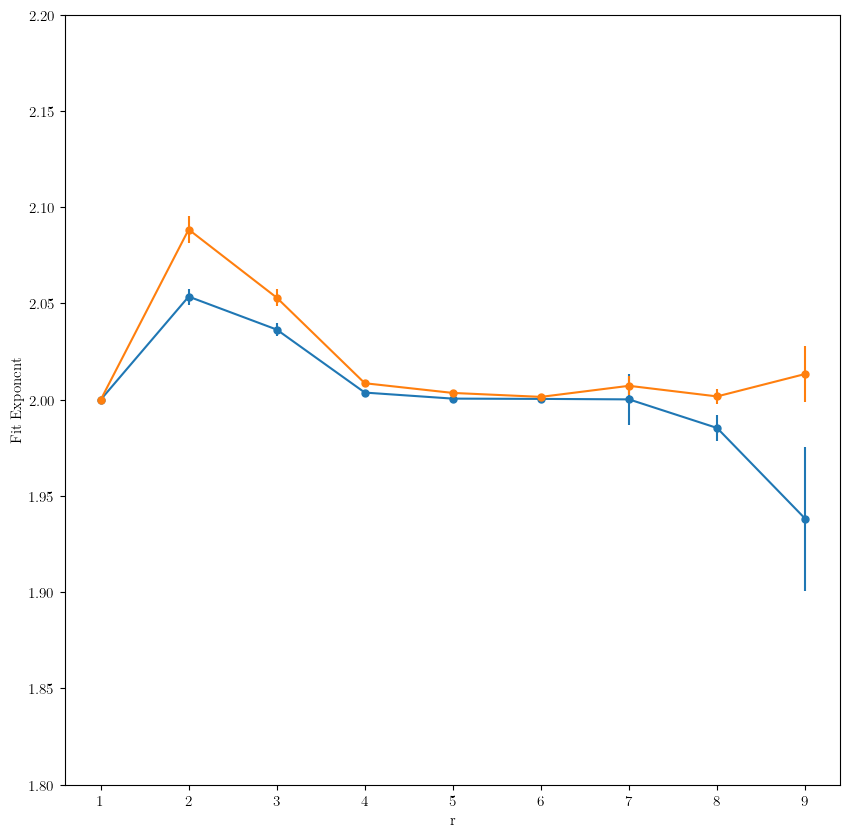

In [249]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(rvals[0:9],[popt_zz[j][1] for j in range(0,9)],yerr=[perr_zz[j][1] for j in range(0,9)],marker="o",ms=5)
#ax.errorbar(rvals[0:8],[popt_zz_nn[j][1] for j in range(0,8)],yerr=[perr_zz_nn[j][1] for j in range(0,8)],marker="o",ms=5)
ax.errorbar(rvals[0:9],[popt_xx[j][1] for j in range(0,9)],yerr=[perr_xx[j][1] for j in range(0,9)],marker="o",ms=5)
#ax.plot(rvals[0:8],[popt_xx_nn[j][1] for j in range(0,8)],marker="o",ms=5)
ax.set_ylabel("Fit Exponent")
ax.set_xlabel("r")
plt.ylim(1.8,2.2)
plt.show()

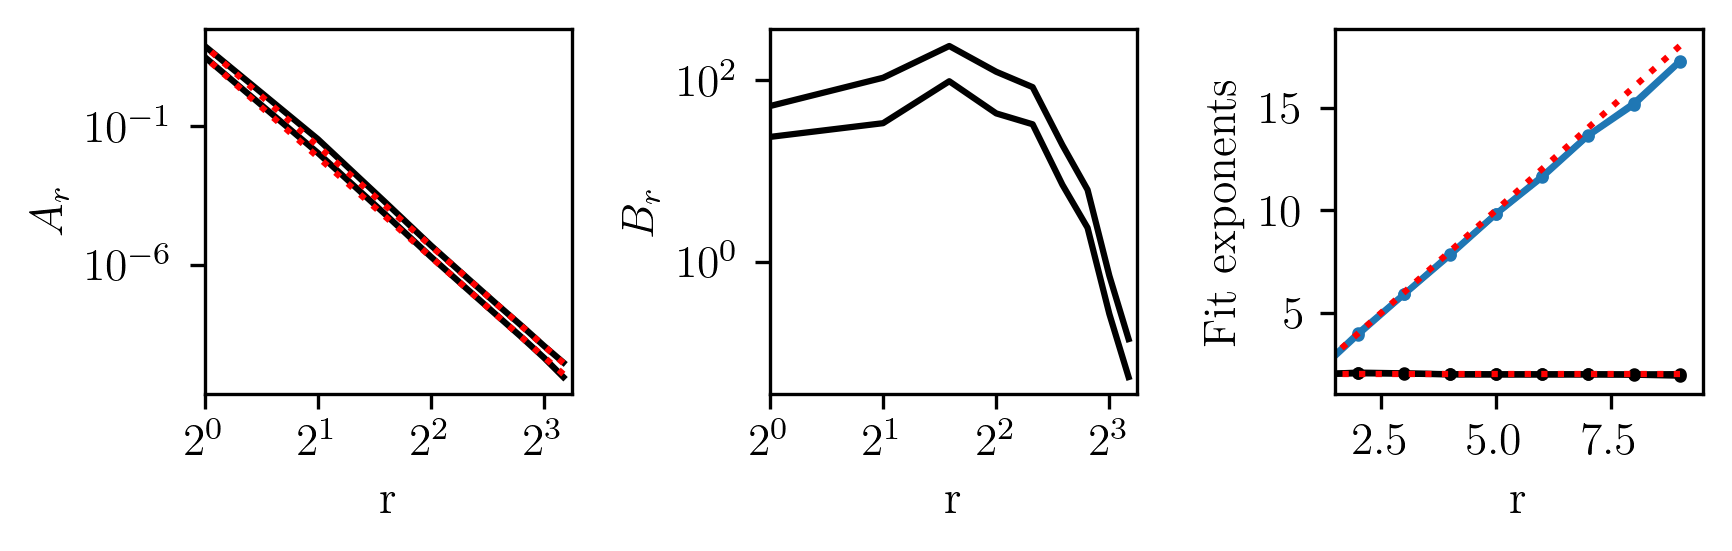

In [517]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=set_size(subplots=(1,3)),dpi=300)

ax1.plot(rvals[0:9],[popt_zz[j][0] for j in range(0,9)],c="black")
ax1.plot(rvals[0:9],32/rvals[0:9]**12,ls="dotted",c="red")
ax1.plot(rvals[0:9],[popt_xx[j][0] for j in range(0,9)],c="black")
ax1.plot(rvals[0:9],5*16/rvals[0:9]**12,ls="dotted",c="red")
ax1.set_yscale("log")
ax1.set_xscale("log",base=2)
ax1.set_xticks([1,2,4,8])
ax1.set_xlim(1,N//2+0.5)
ax1.set_xlabel("r")
ax1.set_ylabel(r"$A_r$")


ax2.plot(rvals[0:9],[popt_zz_nn[j][0] for j in range(0,9)],c="black")

#ax2.plot(rvals[0:8],32/rvals[0:8]**12,ls="dotted",c="red")
ax2.plot(rvals[0:9],[popt_xx_nn[j][0] for j in range(0,9)],c="black")
#ax2.plot(rvals[0:8],5*16/rvals[0:8]**12,ls="dotted",c="red")
ax2.set_yscale("log")
ax2.set_xscale("log",base=2)
ax2.set_xticks([1,2,4,8])
ax2.set_xlim(1,N//2+0.5)
ax2.set_xlabel("r")
ax2.set_ylabel(r"$B_r$")


ax3.plot(rvals[0:9],[popt_zz[j][1] for j in range(0,9)],marker="o",ms=2,c="black")
ax3.plot(rvals[0:9],[popt_xx[j][1] for j in range(0,9)],marker="o",ms=2,c="black")
ax3.plot(rvals[0:9],2*np.ones(9),ls="dotted",c="red")

ax3.plot(rvals[0:9],[popt_zz_nn[j][1] for j in range(0,9)],marker="o",ms=2,c="C0")
ax3.plot(rvals[0:9],[popt_xx_nn[j][1] for j in range(0,9)],marker="o",ms=2,c="C0")
ax3.plot(rvals[0:9],2*rvals[0:9],ls="dotted",c="red")
ax3.set_ylabel("Fit exponents")
ax3.set_xlabel("r")
#ax3.set_yscale("log")
#ax3.set_xscale("log",base=2)
ax3.set_xlim(2-0.5,N//2+0.5)

plt.tight_layout()
plt.savefig(figurepath/"fit_params_all.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()